In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [52]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    
    return df

In [53]:
def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [54]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   #bruk lasso regularisering
   #annen learing rate, 0.0001
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    targets = targets.set_index('time').resample('1H').apply(lambda x: x.max()).dropna(how='all').reset_index()
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date
    


   
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    if merged_data.empty:
      print(f"merged_data is empty for location ")
    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    print(targets.dtypes)
    # Clean up auxiliary columns
    targets = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets, start_date, end_date)
    if observed_resampled.empty:
      print(f"observed_resampled is empty for location ")
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    
    return filtered_data, test_resampled, is_day_feature, targets

In [55]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx','is_in_shadow:idx'],
                    
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True,  
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')

    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00
time              datetime64[ns]
pv_measurement           float64
dtype: object


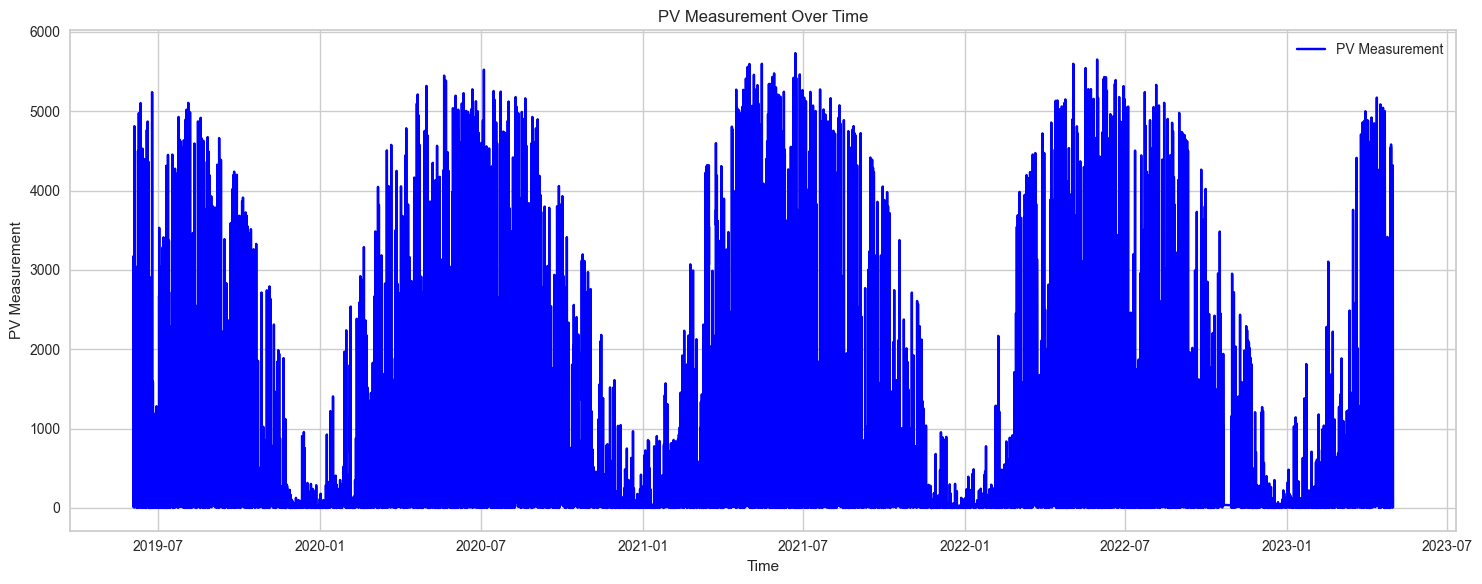

18038 X
18038 y
                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (18038, 48)
4        Transformed data shape  (18038, 60)
5   Transformed train set shape  (12626, 60)
6    Transformed test set shape   (5412, 60)
7              Numeric features           45
8          Categorical features            2
9      Rows with missing values        19.9%
10                   Preprocess         True
11              Imputation type       simple
12           Numeric imputation         mean
13       Categorical imputation         mode
14     Maximum one-hot encoding           25
15              Encoding method         None
16               Fold Generator        KFold
17                  Fold Number           10
18                     CPU Jobs           -1
19                      Use GPU        False
20               Log Experiment        

           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     424.6707  380968.9841  617.2268  0.7845  1.3464  19.3425
1     400.9424  353160.4596  594.2731  0.7965  1.3069  12.1483
2     417.6150  372447.8588  610.2851  0.7976  1.3084   9.9937
3     427.0515  396276.8726  629.5053  0.7983  1.2866   9.9897
4     423.8559  380358.6952  616.7323  0.7863  1.3338  12.1357
5     442.6200  435005.4302  659.5494  0.7757  1.2046   8.6305
6     408.8744  374671.8782  612.1045  0.8013  1.2751   8.0954
7     446.2320  448057.2566  669.3708  0.7773  1.3057  11.9096
8     412.4355  375714.2603  612.9553  0.7945  1.2563  10.7644
9     447.8108  440587.0371  663.7673  0.7847  1.2822  11.0709
Mean  425.2108  395724.8733  628.5770  0.7897  1.2906  11.4081
Std    15.2905   31536.6717   24.8163  0.0087  0.0383   2.9583


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     425.2716  381009.3471  617.2595  0.7845  1.3539  19.7819
1     401.3746  352922.9071  594.0731  0.7966  1.3068  12.2796
2     417.6857  372224.7431  610.1022  0.7977  1.3001  10.1127
3     427.3941  396089.1940  629.3562  0.7984  1.2951  10.0629
4     424.0127  380229.5517  616.6276  0.7864  1.3314  12.2529
5     443.4442  434949.9432  659.5073  0.7758  1.2235   8.8797
6     409.2906  374649.6600  612.0863  0.8013  1.2835   8.1931
7     446.2658  447147.2661  668.6907  0.7778  1.3108  11.9982
8     412.4683  375252.3978  612.5785  0.7947  1.2600  10.8607
9     448.2060  440068.8645  663.3769  0.7849  1.2808  11.4205
Mean  425.5413  395454.3875  628.3658  0.7898  1.2946  11.5842
Std    15.3306   31389.2693   24.7135  0.0086  0.0345   3.0356


           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     425.6304  381313.3342  617.5057  0.7843  1.3557  19.5922
1     401.9470  353503.4678  594.5616  0.7963  1.3134  12.3277
2     417.8804  372256.5960  610.1283  0.7977  1.2983   9.7628
3     428.3713  396657.8779  629.8078  0.7981  1.3024  10.2779
4     424.8586  380762.3865  617.0595  0.7861  1.3376  12.2814
5     443.6670  435042.8479  659.5778  0.7757  1.2263   8.8211
6     410.2354  375103.2193  612.4567  0.8011  1.2836   8.3796
7     446.7240  447276.1117  668.7870  0.7777  1.3100  12.2053
8     412.9125  375672.2835  612.9211  0.7945  1.2676  10.9835
9     448.2818  439844.2538  663.2075  0.7850  1.2841  11.3837
Mean  426.0508  395743.2379  628.6013  0.7896  1.2979  11.6015
Std    15.1967   31214.0269   24.5688  0.0086  0.0343   2.9813
Transformation Pipeline and Model Successfully Saved
float64
date_forecast    datetime64[ns]
is_day:idx              f

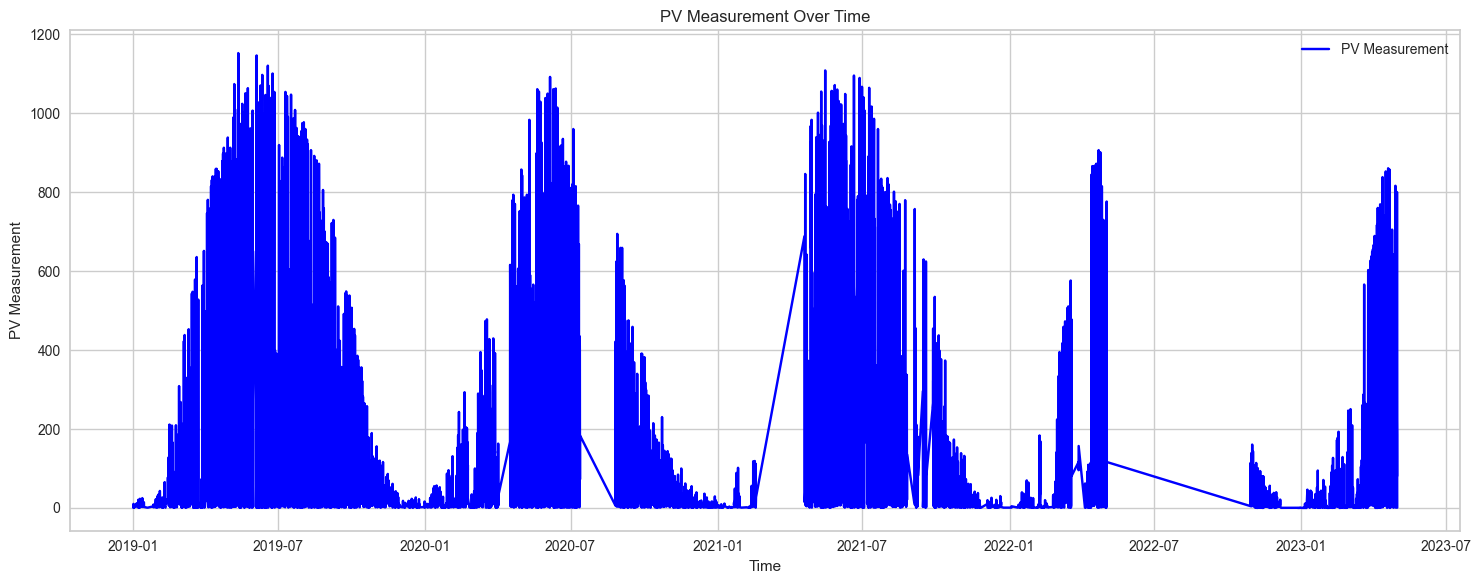

12320 X
12320 y
                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (12320, 48)
4        Transformed data shape  (12320, 60)
5   Transformed train set shape   (8624, 60)
6    Transformed test set shape   (3696, 60)
7              Numeric features           45
8          Categorical features            2
9      Rows with missing values        17.1%
10                   Preprocess         True
11              Imputation type       simple
12           Numeric imputation         mean
13       Categorical imputation         mode
14     Maximum one-hot encoding           25
15              Encoding method         None
16               Fold Generator        KFold
17                  Fold Number           10
18                     CPU Jobs           -1
19                      Use GPU        False
20               Log Experiment        

          MAE         MSE      RMSE      R2   RMSLE      MAPE
Fold                                                         
0     72.1900  11592.5506  107.6687  0.8432  0.9407    2.5372
1     69.5289  12229.5072  110.5871  0.8214  0.9998  195.4119
2     72.2383  12592.5821  112.2167  0.8266  1.0451    3.8291
3     64.2824   9647.7647   98.2230  0.8464  1.0013    3.9564
4     69.6744  10371.0542  101.8384  0.8268  0.9187    4.9601
5     71.4242  11392.2760  106.7346  0.8441  0.9582    4.1477
6     70.1595  11580.5781  107.6131  0.8221  1.0035    3.0327
7     70.4227  11856.6947  108.8885  0.8189  1.0479    3.7916
8     70.6412  11123.5528  105.4683  0.8232  1.0334    4.4088
9     68.8918  11036.3784  105.0542  0.8440  1.0114    3.5099
Mean  69.9453  11342.2939  106.4292  0.8317  0.9960   22.9585
Std    2.1602    818.1106    3.8871  0.0107  0.0416   57.4881


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE         MSE      RMSE      R2   RMSLE      MAPE
Fold                                                         
0     71.9857  11510.2525  107.2858  0.8443  0.9413    2.5971
1     69.5932  12171.5364  110.3247  0.8223  1.0155  233.0976
2     72.0756  12522.0216  111.9018  0.8276  1.0307    3.8328
3     64.3846   9620.0470   98.0818  0.8469  1.0143    3.9359
4     69.7893  10353.2838  101.7511  0.8271  0.9362    4.3690
5     71.3689  11346.7788  106.5213  0.8447  0.9569    4.3604
6     70.3279  11546.3476  107.4539  0.8226  1.0049    3.0622
7     70.7291  11849.4293  108.8551  0.8190  1.0217    3.2649
8     70.6518  11093.9248  105.3277  0.8237  1.0471    4.8980
9     68.9253  10991.2425  104.8391  0.8446  1.0101    3.5328
Mean  69.9831  11300.4864  106.2342  0.8323  0.9979   26.6951
Std    2.0996    807.3522    3.8435  0.0108  0.0368   68.8039


          MAE         MSE      RMSE      R2   RMSLE      MAPE
Fold                                                         
0     72.1800  11584.6257  107.6319  0.8433  0.9373    2.6362
1     69.5158  12117.1892  110.0781  0.8231  1.0093  225.9731
2     71.9847  12550.2784  112.0280  0.8272  1.0216    3.8405
3     64.1954   9612.0836   98.0412  0.8470  1.0092    3.9313
4     69.9804  10347.5854  101.7231  0.8272  0.9556    5.0443
5     71.5174  11367.6440  106.6192  0.8444  0.9598    4.3989
6     70.4550  11553.9397  107.4893  0.8225  1.0082    3.1203
7     70.7195  11843.8410  108.8294  0.8191  1.0145    3.2601
8     70.7153  11098.4547  105.3492  0.8236  1.0477    4.9285
9     68.8766  10995.9887  104.8618  0.8445  1.0107    3.5231
Mean  70.0140  11307.1631  106.2651  0.8322  0.9974   26.0656
Std    2.1776    810.2787    3.8586  0.0106  0.0328   66.6398
Transformation Pipeline and Model Successfully Saved
float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: 

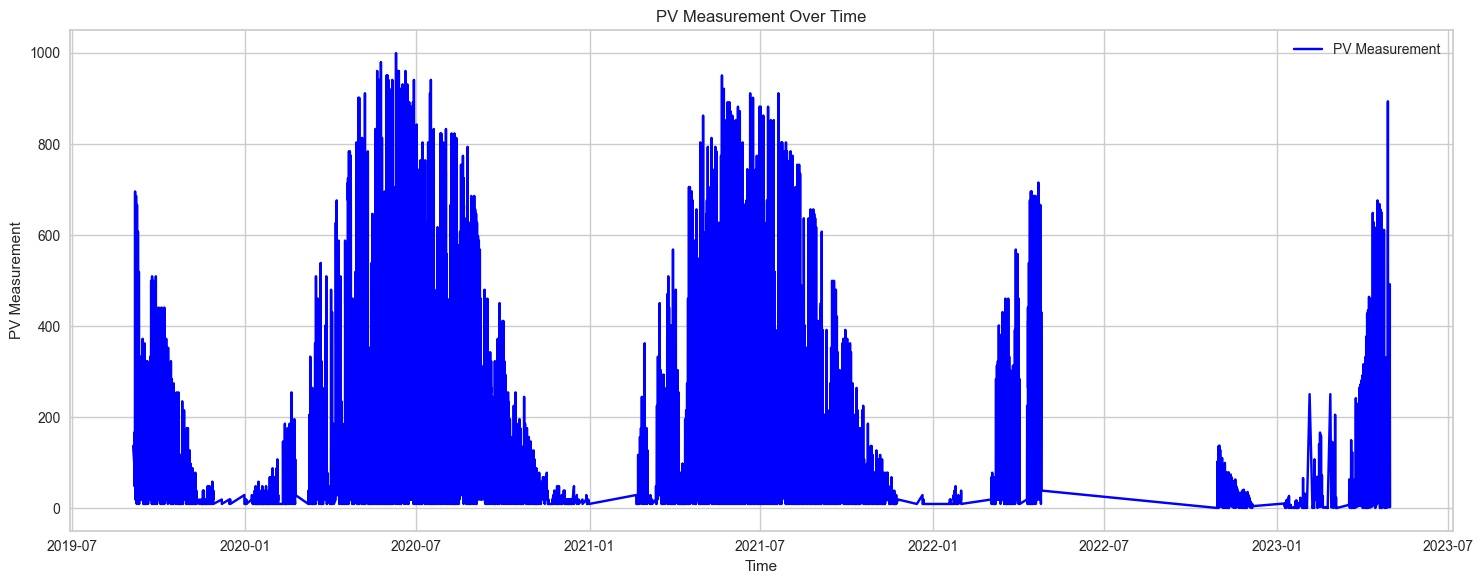

9957 X
9957 y
                    Description       Value
0                    Session id         123
1                        Target      target
2                   Target type  Regression
3           Original data shape  (9957, 48)
4        Transformed data shape  (9957, 60)
5   Transformed train set shape  (6969, 60)
6    Transformed test set shape  (2988, 60)
7              Numeric features          45
8          Categorical features           2
9      Rows with missing values       23.0%
10                   Preprocess        True
11              Imputation type      simple
12           Numeric imputation        mean
13       Categorical imputation        mode
14     Maximum one-hot encoding          25
15              Encoding method        None
16               Fold Generator       KFold
17                  Fold Number          10
18                     CPU Jobs          -1
19                      Use GPU       False
20               Log Experiment       False
21              Ex

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     65.3056  9584.1533  97.8987  0.8104  0.6903  0.9497
1     57.8646  7782.7955  88.2202  0.8364  0.7044  1.0482
2     62.0150  9058.8910  95.1782  0.8054  0.7564  0.8945
3     59.3805  8054.0008  89.7441  0.8241  0.7926  1.0688
4     64.6240  9267.4578  96.2676  0.8013  0.7683  1.1803
5     59.1528  8037.0534  89.6496  0.8419  0.7460  1.1455
6     60.7523  9186.9908  95.8488  0.7765  0.7898  1.2375
7     58.7971  8328.8731  91.2627  0.8434  0.7324  0.8965
8     63.4533  9714.1675  98.5605  0.8086  0.6861  1.0402
9     59.0827  7707.5852  87.7929  0.8247  0.7428  1.0580
Mean  61.0428  8672.1968  93.0423  0.8173  0.7409  1.0519
Std    2.5131   728.7800   3.9146  0.0199  0.0361  0.1093


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     64.9391  9484.6810  97.3893  0.8124  0.6729  0.9290
1     57.8195  7743.9275  87.9996  0.8372  0.6908  1.0570
2     62.0839  9031.1492  95.0324  0.8060  0.7286  0.9284
3     59.7024  8103.9792  90.0221  0.8230  0.7902  1.0689
4     64.4544  9178.0692  95.8022  0.8032  0.7939  1.2184
5     59.0166  7986.7564  89.3687  0.8429  0.7506  1.1740
6     60.7942  9163.5474  95.7264  0.7770  0.7908  1.2740
7     58.8527  8315.8746  91.1914  0.8437  0.7497  0.9098
8     63.2198  9621.2906  98.0882  0.8104  0.7014  1.0396
9     59.1245  7673.5942  87.5991  0.8255  0.7559  1.0887
Mean  61.0007  8630.2869  92.8219  0.8181  0.7425  1.0688
Std    2.3970   703.4260   3.7915  0.0196  0.0412  0.1190


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     65.2454  9492.6211  97.4301  0.8122  0.6852  0.9557
1     58.0729  7762.6492  88.1059  0.8368  0.6982  1.0757
2     62.3138  9012.8259  94.9359  0.8064  0.7318  0.9329
3     59.7172  8073.9219  89.8550  0.8236  0.7866  1.0792
4     64.6841  9167.2632  95.7458  0.8034  0.8074  1.2788
5     59.2610  8002.5073  89.4567  0.8426  0.7481  1.1807
6     60.8584  9160.2382  95.7091  0.7771  0.8003  1.2758
7     58.8184  8316.4997  91.1948  0.8437  0.7264  0.8982
8     63.2265  9623.9589  98.1018  0.8104  0.7054  1.0358
9     59.3323  7691.9725  87.7039  0.8250  0.7747  1.1155
Mean  61.1530  8630.4458  92.8239  0.8181  0.7464  1.0828
Std    2.4258   698.7040   3.7640  0.0195  0.0417  0.1270
Transformation Pipeline and Model Successfully Saved
float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


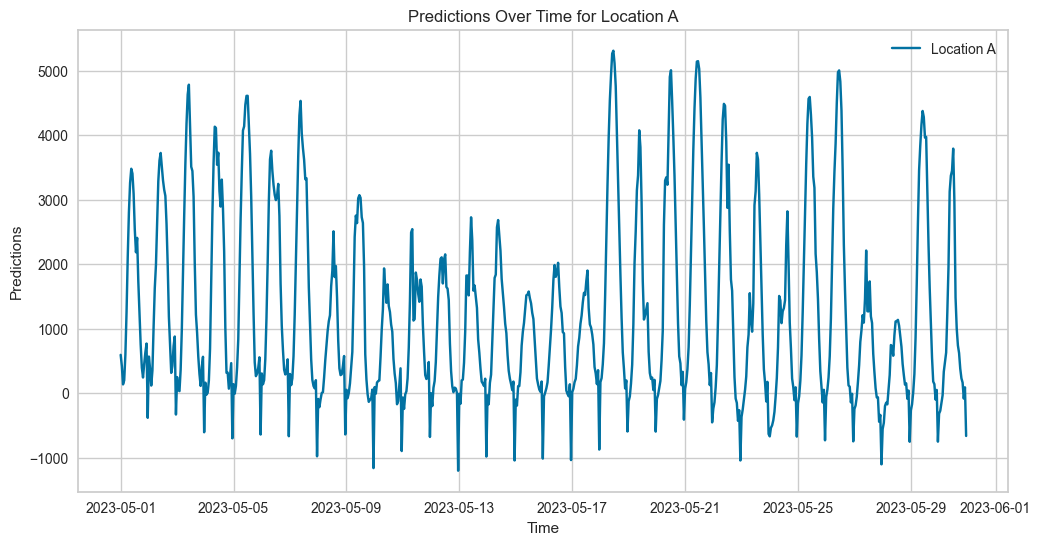

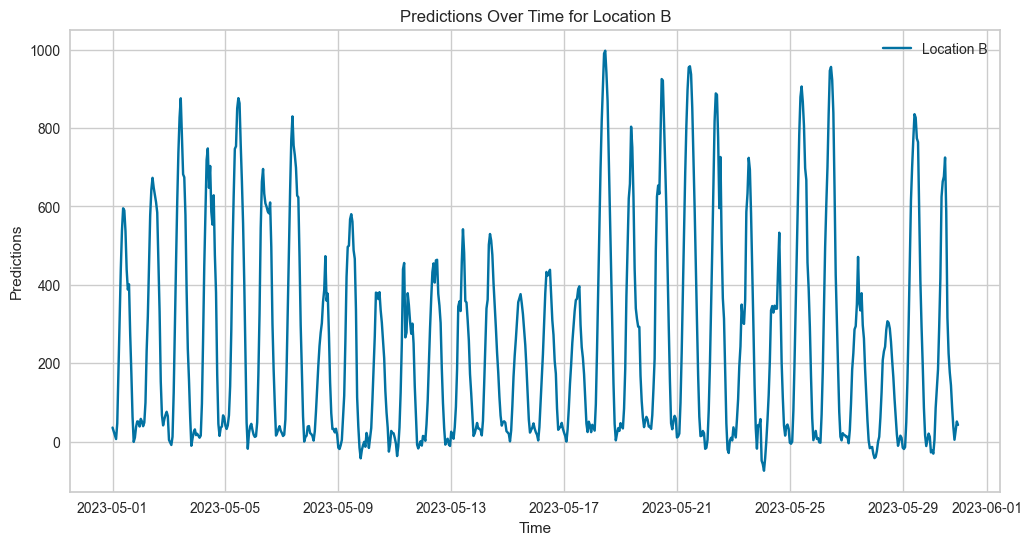

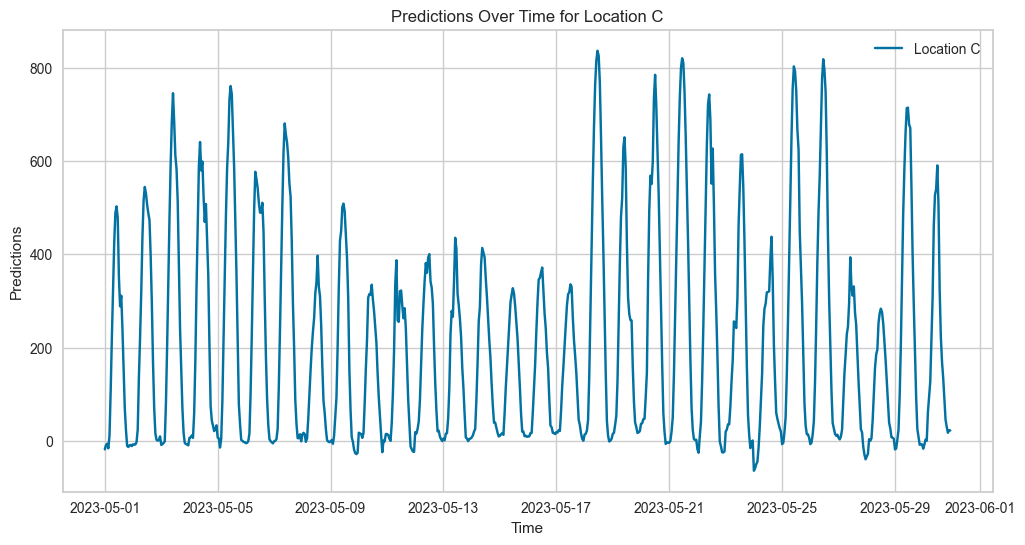

In [56]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    '''train_non_zero = train[train['pv_measurement'] != 0]
    if train_non_zero.empty:
        print(f"train_non_zero is empty for location {loc}")

    # Get the timestamps of these rows
    valid_timestamps = train_non_zero['time'].tolist()
    
    # Filter the X_* dataframes based on these timestamps
    X_train_estimated = X_train_estimated[X_train_estimated['date_forecast'].isin(valid_timestamps)]
    X_train_observed = X_train_observed[X_train_observed['date_forecast'].isin(valid_timestamps)]
    #X_test_estimated = X_test_estimated[X_test_estimated['date_forecast'].isin(valid_timestamps)]
    if X_train_estimated.empty:
        print(f"X_train_estimated is empty for location {loc}")'''

    #lage dag og måned feature der man aggregerer opp 
    # Preprocess data
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    # Ensure X and y have the same length
    print(len(X_train), 'X')
    print(len(y_train),'y')
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]
    
    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)
    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
        #print(predictions.columns)
        # Assuming 'predictions' is the output from predict_model
    final_predictions = predictions['prediction_label']
    print(final_predictions.dtypes)
    print(is_day_feature.dtypes)
    # Multiply final predictions with the 'is_day:idx' values
    adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
    adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
    all_predictions.append(adjusted_final_predictions)  

        # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': predictions['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)


# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [57]:
print(X_test.shape)


(720, 48)


In [58]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)